# Experiment Results

Goal: Begin exploring the transformation space

####  Method
1. Defined transforms 
    - Jitter
    - Rotate
    - Magnitude Warp
2. Grid Search different parameters for each transform
    - Set minimum by eye-balling transform with zero affect on original data
    - set maximum by eye-balling indistinguishable original data after transform

In [22]:
import pickle
from scipy import interpolate
from sklearn import metrics
import matplotlib.pyplot as plt
from Evaluation import evaluation
import numpy as np

Y_columns = {'subId': 0,
 'session': 1,
 'trialId': 2,
 'seqId': 3,
 'original_trial_length_before_padding': 4}

train_data = np.load('Data/train_data.npz')
test_data = np.load('Data/test_data.npz')
X_train = train_data['X_train']
Y_train = train_data['Y_train']
X_test = test_data['X_test']
Y_test = test_data['Y_test']

window_sizes = [1,5,10]
plt.rcParams["figure.figsize"] = (10,8)

with open("metrics_dict.pkl", "rb") as f:
    metric_dicts = pickle.load(f)
    
def plot(to_evaluate):
    for window_size in window_sizes:
        # for i, k in enumerate(metric_dicts.items()):
        for i, (k, v) in enumerate(metric_dicts.items()):
            try:
                if k not in to_evaluate:
                    continue
            except Exception as e:
                continue
            metric_dict = v
            model_name = k
            if i == 0:
                plot_random = True
            else:
                plot_random = False
            window_size = str(window_size)
            evaluation.avg_fnr_fpr_curve(metric_dict[window_size]['fpr'], metric_dict[window_size]['tpr'], 
                    label = model_name, plot_random=plot_random,
                    title = 'Window_size: ' + window_size, plot_statistics = False,
                    plot_points = 1000, ncol=1,
                    plot_legend=False,
                    fontsize = 14, xscale = 'log',
                    setting = 'identification')
        # plt.show()
        plt.savefig("./detcurve.jpg")
        break
        
        
def plot_eer(to_evaluate):
    fig, axs = plt.subplots(len(window_sizes), 1, figsize=(16,20))
    for idx, window_size in enumerate(window_sizes):
        ax = axs[idx]
        mean_eer = []
        std_eer = []
        sample_names = []
        for sample_name, samples in to_evaluate.items():
            eers = []
            for metric_name in samples:
                window_size = str(window_size)
                v = metric_dicts[metric_name][str(window_size)]
                eers.append(get_eer(v['fpr'], v['tpr']))
            mean_eer.append(np.mean(eers))
            std_eer.append(np.std(eers))
            sample_names.append(sample_name)
        x_pos = np.arange(len(sample_names))
        ax.bar(x_pos, mean_eer, yerr=std_eer, align='center', alpha=0.5, ecolor='black', capsize=10)
        ax.set_title(f'Experiments with window size: {window_size}')
        ax.set_ylabel('EER Value')
        ax.yaxis.grid(True)
        print(idx)
        if idx == len(window_size) == 2:
            ax.set_xticks(x_pos, rotation=60)
            ax.set_xticklabels(sample_names, rotation=90)
        else:
            ax.get_xaxis().set_visible(False)
    plt.savefig('./eerexp.png')
        
                  
def get_eer(fprs, tprs, plot_points=1000):
    """
    Plot average roc curve from multiple fpr and tpr arrays of multiple cv-folds

    :param fprs: list of fpr arrays for the different folds
    :param tprs: list of tpr arrays for the different folds
    """
    
    eers = []
    for i, fpr in enumerate(fprs):
        for idx, fpr_val in enumerate(fpr):
            if fpr_val > 1 - tprs[i][idx]:
                eers.append(fpr_val)       
                break

    eer = np.mean(eers)
    return eer

In [2]:
no_aug = [k for k in metric_dicts.keys() if len(k) >= 1 and 'run' in k[0][0]]
rotate_less_than_05 = [k for k in metric_dicts.keys() if len(k) >= 1 and 'rotate' in k[0][0] and 0.5 == k[0][1]]
warp_15_knots_4 = [k for k in metric_dicts.keys() if len(k) >= 1 and 'mag_warp' in k[0][0] and 0.15 == k[0][1]]
warp_05_knots_4 = [k for k in metric_dicts.keys() if len(k) >= 1 and 'mag_warp' in k[0][0] and 0.051 == k[0][1]]
warp_15_knots_2 = [k for k in metric_dicts.keys() if len(k) >= 1 and 'mag_warp' in k[0][0] and type(k[0][1]) == tuple and 2 == k[0][1][1]]
# warp_15_knots_2 = [k for k in metric_dicts.keys() if len(k) >= 1 and 'mag_warp' in k[0][0] and type(k[0][1]) == 'tuple' and 2 == k[0][1][1]]
warp_15_knots_8 = [k for k in metric_dicts.keys() if len(k) >= 1 and 'mag_warp' in k[0][0] and type(k[0][1]) == tuple and 8 == k[0][1][1]]

to_evaluate = {
    f'No aug. Items: {len(no_aug)}': no_aug ,
    f'Rotate Less than 0.5. Items {len(rotate_less_than_05)}': rotate_less_than_05,
    f'Warp 0.15 w 4 knots. Items {len(warp_15_knots_4)}': warp_15_knots_4,
    f'Warp 0.05 w 4 knots. Items {len(warp_05_knots_4)}': warp_05_knots_4,
    f'Warp 0.15 w 2 knots. Items {len(warp_15_knots_2)}': warp_15_knots_2,
    f'Warp 0.15 w 8 knots. Items {len(warp_15_knots_8)}': warp_15_knots_8,
}
to_evaluate

{'No aug. Items: 12': [(('run', 0),),
  (('run', 1),),
  (('run', 2),),
  (('run', 3),),
  (('run', 0), ('batch_size', 32)),
  (('run', 1), ('batch_size', 32)),
  (('run', 2), ('batch_size', 32)),
  (('run', 3), ('batch_size', 32)),
  (('run', 4), ('batch_size', 32)),
  (('run', 5), ('batch_size', 32)),
  (('run', 6), ('batch_size', 32)),
  (('run', 7), ('batch_size', 32))],
 'Rotate Less than 0.5. Items 8': [(('rotate', 0.5), ('run', 0)),
  (('rotate', 0.5), ('run', 1)),
  (('rotate', 0.5), ('run', 2)),
  (('rotate', 0.5), ('run', 3)),
  (('rotate', 0.5), ('run', 4)),
  (('rotate', 0.5), ('run', 5)),
  (('rotate', 0.5), ('run', 6)),
  (('rotate', 0.5), ('run', 7))],
 'Warp 0.15 w 4 knots. Items 8': [(('mag_warp', 0.15),
   ('run', 0),
   ('batch_size', 32)),
  (('mag_warp', 0.15), ('run', 1), ('batch_size', 32)),
  (('mag_warp', 0.15), ('run', 2), ('batch_size', 32)),
  (('mag_warp', 0.15), ('run', 3), ('batch_size', 32)),
  (('mag_warp', 0.15), ('run', 4), ('batch_size', 32)),
  (('m

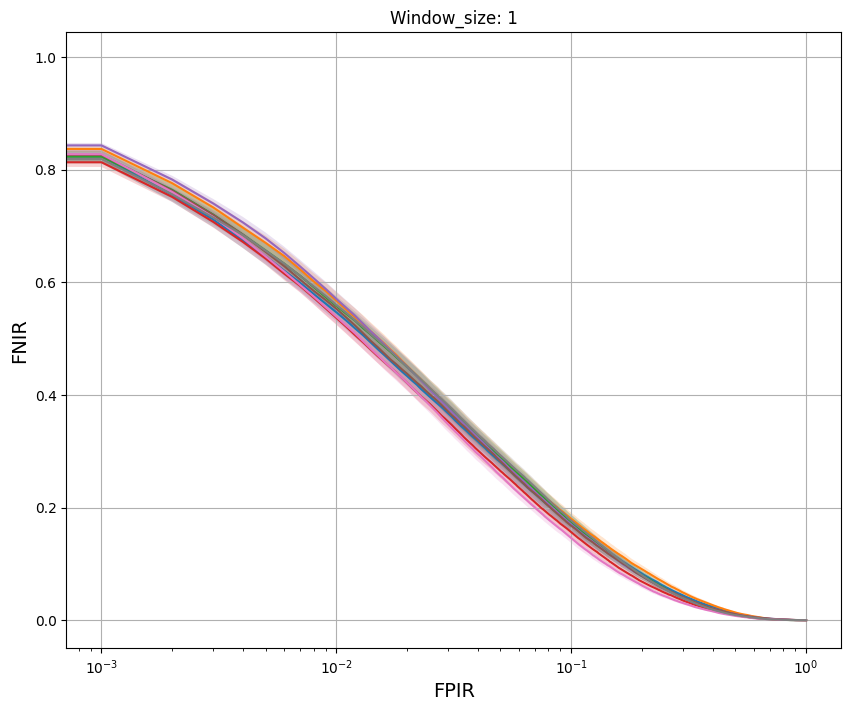

In [12]:
plot(to_evaluate['Warp 0.15 w 2 knots. Items 8'])

0
1
2


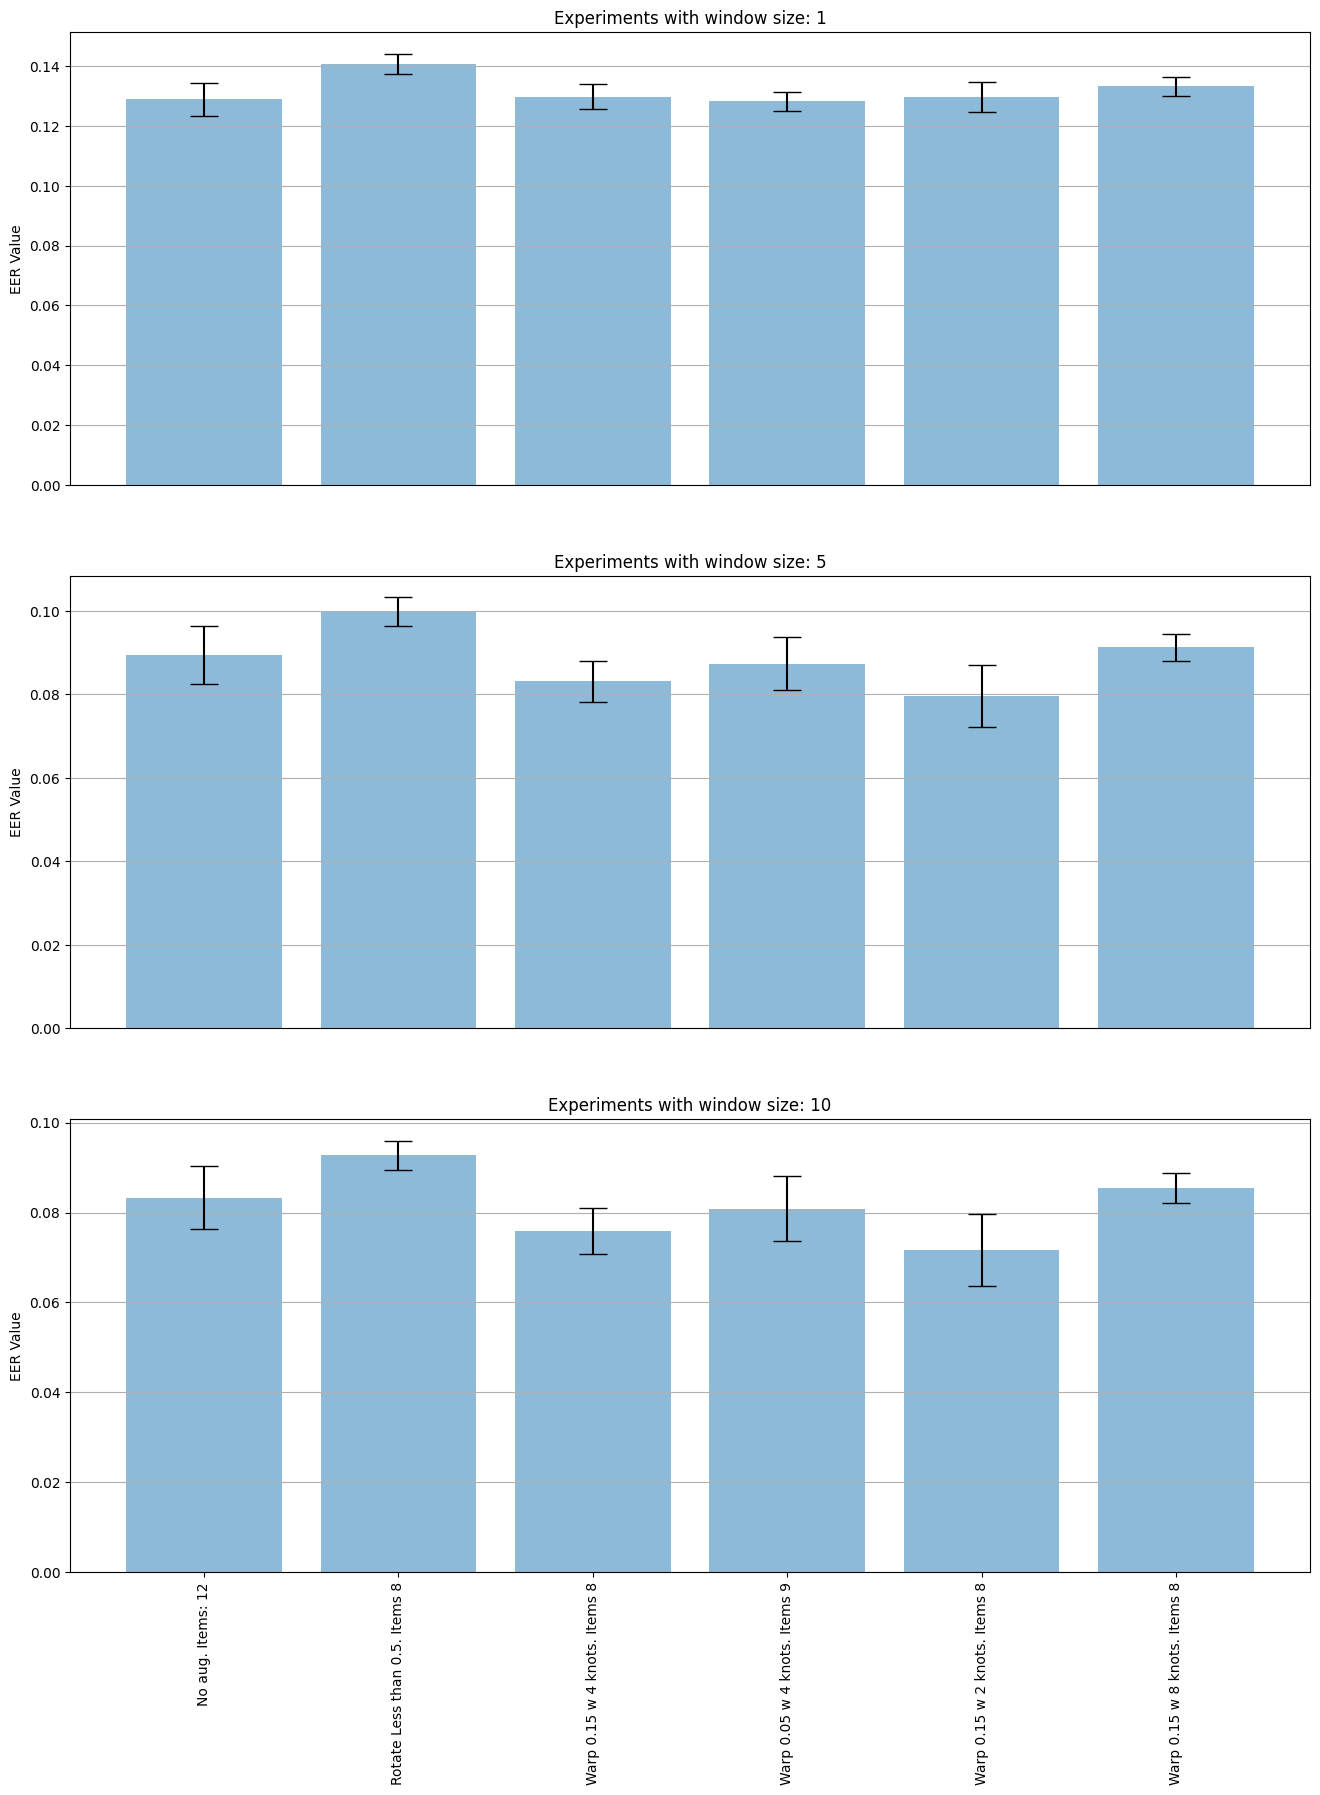

In [23]:
plot_eer(to_evaluate)